This roughly demonstrates the model used in Freeze-Thaw BO (Swersky et al 2014).

Note the implementation for Demo 2 is not what is in the paper! I made up this implementation and it's just meant to be a high-level illustration.

Also note that the authors have a project on Bayesian Optimization https://github.com/HIPS/Spearmint and Freeze-Thaw BO is probably implemented in there somewhere - I didn't have enough time to dig through their code.

In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt
from IPython.display import display

# Import the important stuff
import GPy
import numpy as np

In [2]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

In [3]:
# Latex in matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
# Ignore all warnings (they're mostly minor math issues)
import warnings
warnings.filterwarnings('ignore')

# Demo 1

Exponential Decay Kernel

In [5]:
from GPy.kern import Kern
from GPy.core.parameterization import Param
import numpy as np

class ExpDecayKern(Kern):
    '''Quick & dirty implementation of the Exponential Decay Kernel'''
    
    def __init__(self,input_dim,alpha=1.,beta=1.):
        super(ExpDecayKern, self).__init__(input_dim, active_dims=None, name='exp_decay')
        assert input_dim == 1, "For this kernel we assume input_dim=1 (loss at time)"
        self.alpha = Param('alpha', alpha)
        self.beta = Param('beta', beta)
        # alpha and beta are params of the gamma dist, so they're > 0
        self.alpha.constrain_positive()
        self.beta.constrain_positive()
        self.link_parameters(self.alpha, self.beta)
        
    def K(self,X,X2):
        if X2 is None: X2 = X
        result = np.zeros([len(X), len(X2)])
        for i in range(len(X)):
            for j in range(len(X2)):
                result[i,j] = (self.beta**self.alpha) / ((X[i] + X2[j] + self.beta)**self.alpha)
        return result
    
    def Kdiag(self,X):
        return np.diag(self.K(X, None))
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        dk_da = (self.beta**self.alpha) * ((self.beta + X + X2)**(-self.alpha)) * (np.log(self.beta) - np.log(self.beta + X + X2))
        dk_db = self.alpha * (self.beta**(self.alpha-1)) * (X + X2) * ((self.beta + X + X2)**(-self.alpha-1))
        
        self.alpha.gradient = np.sum(dk_da*dL_dK)
        self.beta.gradient = np.sum(dk_db*dL_dK)

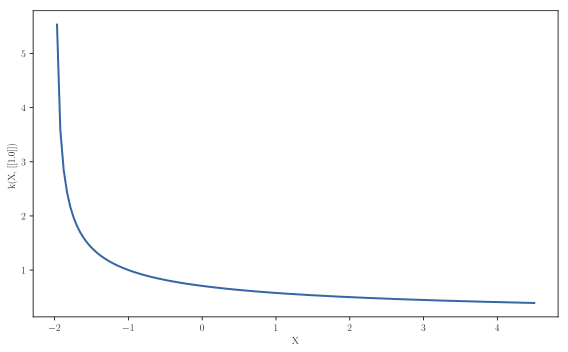

In [6]:
ker1 = ExpDecayKern(input_dim=1, alpha=.5, beta=1.)
_ = ker1.plot()

### Simulate some data

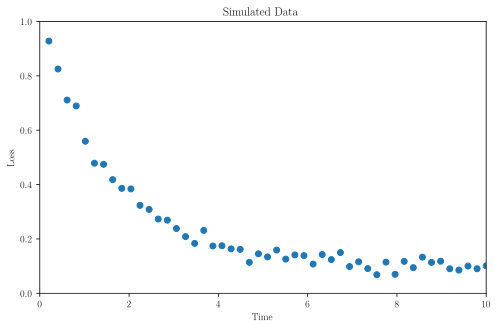

In [7]:
real_lambda = 0.6
X = np.linspace(0,10)
X = X.reshape(X.shape[0], 1)
Y = np.exp(-real_lambda * X) * 0.9 + 0.1
Y += np.random.normal(0,0.02,size=(X.shape[0],1))

plt.scatter(X, Y)
plt.ylim(0, 1)
plt.xlim(0, 10)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Simulated Data')
#plt.savefig('demo1_0.png', dpi=200)

### Fit the data a batch at a time:

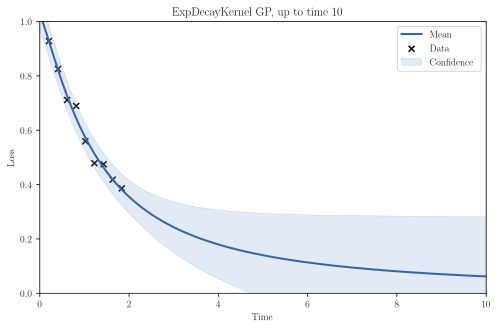

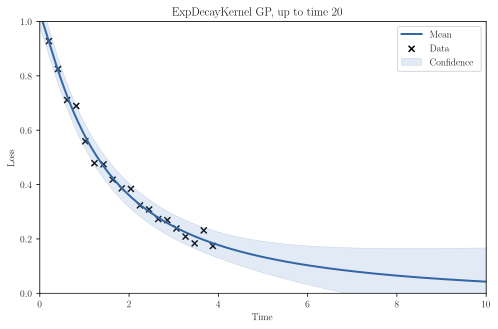

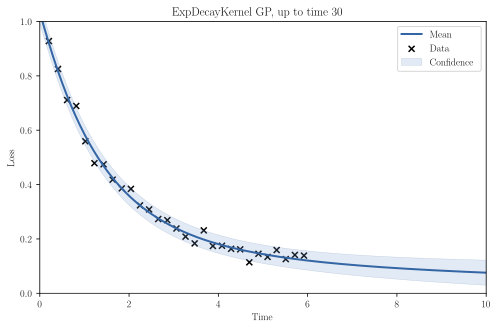

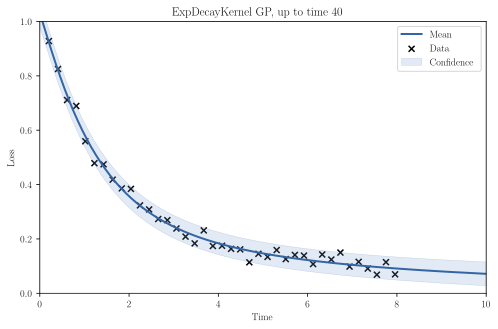

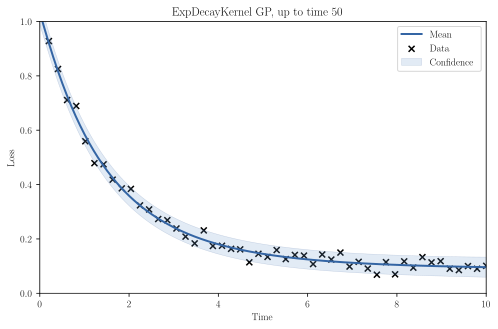

In [8]:
T = 10 # batch size <- I set this to 1 in the demo.
for upto in range(T,X.shape[0]+T,T):
    ker1 = ExpDecayKern(input_dim=1, alpha=.5, beta=1.)
    m = GPy.models.gp_regression.GPRegression(X[:upto,:], Y[:upto,:], kernel=ker1)
    m.optimize(messages=False)
    
    m.plot(ax=plt.gca(), plot_limits=[0,10])
    plt.ylim(0, 1)
    plt.xlabel('Time')
    plt.ylabel('Loss')
    plt.title('ExpDecayKernel GP, up to time {}'.format(upto))
    #plt.savefig('demo1_{}.png'.format(upto), dpi=200)
    plt.show()

# Demo 2

Shows how Global GP (Asymptotic GP) change as each training curve GP changes.

Asymptote Model: GP(m, Matern_5/2), where m is a constant.

Training Curve Model: GP(f, ExpDecayKern), where the prior for f (a constant) is drawn from the Asymptote Model.

To keep things simple there is only 1 hyperparameter.

We first fit each Training Curve Model for T timesteps, then use the posterior estimates of asymptotes to fit the Asymptote Model, and repeat.

### Create some fake data

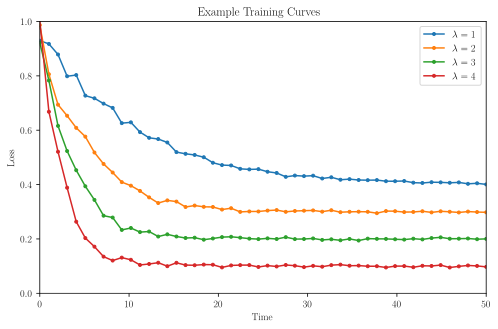

In [9]:
SEED = 1337
np.random.seed(SEED)

MAXTIME = 50

hypers = [1, 2, 3, 4]
asymps = [0.4, 0.3, 0.2, 0.1]
n_curves = len(hypers)

def create_fake_data(n=20,exp_lambda=0.6,asymp=0.5,gaussian_noise=0.1):
    X = np.linspace(0,MAXTIME,MAXTIME)
    X = X.reshape(X.shape[0], 1)
    Y = np.exp(-exp_lambda * X)
    Y = Y * (1-asymp) + asymp
    noise = np.random.normal(0,1/(X+1) * gaussian_noise)
    noise.reshape(noise.shape[0],1)
    Y += noise
    return X, Y

i = 0
data = []
for hyper, asymp in zip(hypers, asymps):
    X,Y = create_fake_data(exp_lambda=hyper/10, asymp=asymp)
    data.append((X,Y))
    
    plt.plot(X, Y, '.-', label=r'$\lambda$ = {}'.format(hyper))
    plt.ylim(0,1)
    i += 1
plt.title('Example Training Curves')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.xlim([0,MAXTIME])
plt.legend()
#plt.savefig('demo2_0_{}_training_curves.png'.format(SEED), dpi=200)
plt.show()

In [10]:
from GPy.mappings.constant import Constant

def fit_tc(X, Y, alpha=0.5, beta=1., m_value=0.0, noise_var=0.1, verbose=False):
    '''Fit training curve'''
    ker1 = ExpDecayKern(input_dim=1, alpha=alpha, beta=beta)
    if m_value is None:
        m = GPy.models.gp_regression.GPRegression(X, Y, kernel=ker1, noise_var=noise_var)
    else:
        mf = Constant(1,1,value=m_value,name='my_mapping')
        m = GPy.models.gp_regression.GPRegression(X, Y, kernel=ker1, mean_function=mf, noise_var=noise_var)    
    m.optimize(messages=verbose)
    return m

def fit_asm(X, Y, verbose=False):
    '''Fit asymptote'''
    global_kern = GPy.kern.Matern52(input_dim=1, variance=1, lengthscale=1)
    mf = Constant(1,1,value=0.1)
    gm = GPy.models.gp_regression.GPRegression(X, Y, kernel=global_kern, mean_function=mf)
    gm.optimize(messages=verbose)
    if verbose:
        gm.plot()
        display(gm)
    return gm

# # Test fit_asm
# X = np.array([[1], [1], [1.5], [2], [3]])
# Y = np.array([[1], [0], [-8], [-6], [5]])
# gm = fit_asm(X, Y, verbose=False)
# gm.plot(samples=1)

In [11]:
def get_asymptote(exp_model, n=100):
    # Hacky way to get an asymptote - just get the prediction at n.
    # We may want to use _this_ in practice because n is how long we'd realistically wait.
    #return exp_model.predict_noiseless(np.array([[n]]))[0][0][0]
    
    # Alternatively, we can return the posterior f
    return exp_model.param_array[0]

In [12]:
# Couldn't figure out why appending a row to empty numpy array doesn't work...
# So came up with this workaround:
def append(arr, el):
    if arr is None: arr = np.array([[el]])
    else: arr = np.append(arr, [[el]], axis=0)
    return arr

# # Test
# aa = None
# aa = append(aa, 1)
# print(aa)
# aa = append(aa, 2)
# print(aa)

### Run it!

In [13]:
# Reset
gX = None
gY = None
ran_upto = [0 for i in range(n_curves)]
itr = 0
T = 10 # Time granularity <- I set this to 1 in demo.
gm = None

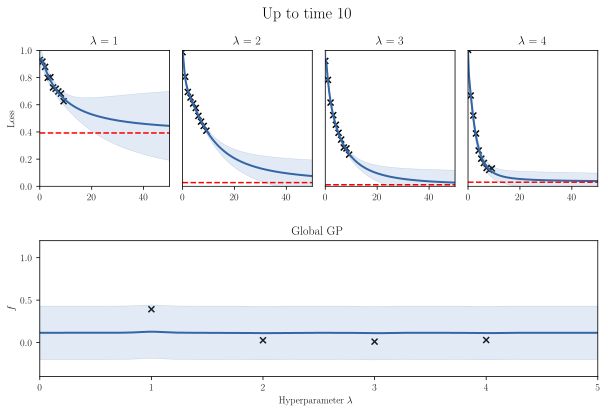

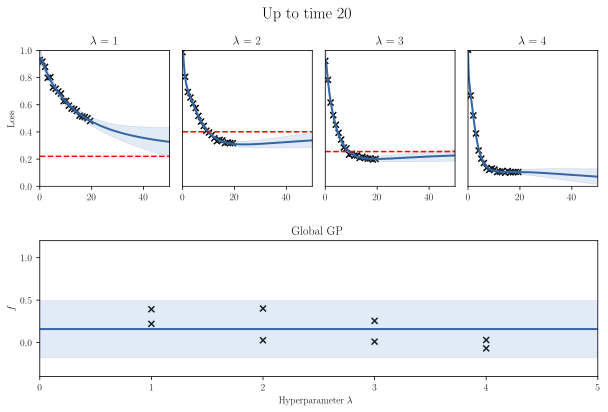

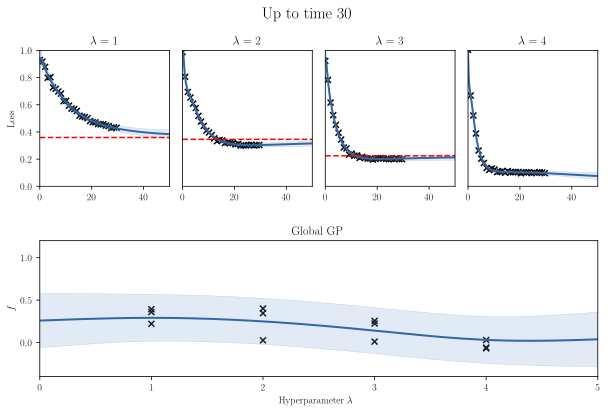

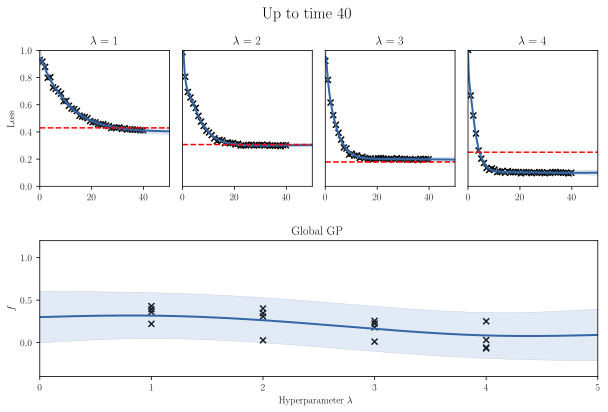

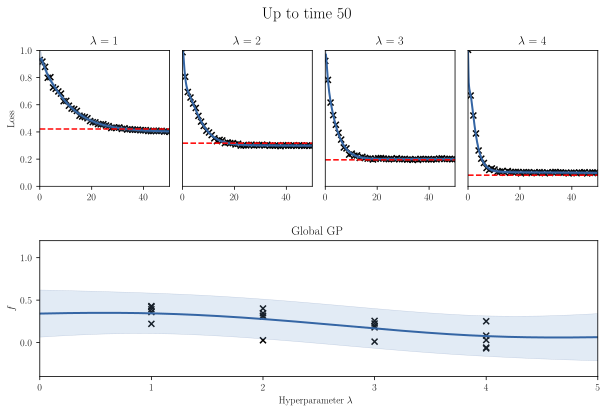

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Plotting in a grid comes from: https://stackoverflow.com/a/34934631

for _ in range(int(MAXTIME/T)):

    # Plotting...
    fig = plt.figure(figsize=(10, 6))
    outer = gridspec.GridSpec(2, 1, hspace=0.4)
    time = (int(itr / n_curves)+1)*T
    fig.suptitle("Up to time {}".format(time), fontsize=16)
    top = gridspec.GridSpecFromSubplotSpec(1, n_curves, subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for _ in range(n_curves): # Train all the models for T timesteps
        i = itr % n_curves # cycle through the curves

        hyper = hypers[i]
        ran_upto[i] += T
        # Get an asymptote prior
        if gm:
            asymp_prior = gm.predict_noiseless(np.array([[hyper]]))[0][0][0]
        else:
            asymp_prior = 0.1 # a sensible default asymptote
        # Fit the training curve GP
        X, Y = data[i]
        m = fit_tc(X[0:ran_upto[i], :], Y[0:ran_upto[i], :], m_value=asymp_prior, noise_var=0.1)
        # Add to the list of data to train Global GP
        asymp = get_asymptote(m)
        gX = append(gX, hyper)
        gY = append(gY, asymp)

        # Plotting...
        ax = plt.Subplot(fig, top[i])
        ax.set_title(r'$\lambda$ = {}'.format(hyper))
        if i == 0:
            ax.set_ylabel('Loss')
        else:
            ax.set_yticks([])
        m.plot(ax=ax, plot_limits=[0,MAXTIME], legend=False)
        ax.set_ylim(0,1)
        ax.axhline(asymp, color='r', ls='--')
        fig.add_subplot(ax)

        itr += 1

    # Fit global GP
    gm = fit_asm(gX, gY)

    # Plotting...
    bottom = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    ax = plt.Subplot(fig, bottom[0])
    gm.plot(ax=ax, plot_limits=[0,5], legend=False)
    ax.set_title('Global GP')
    ax.set_ylim(-0.4,1.2)
    ax.set_xlabel(r'Hyperparameter $\lambda$')
    ax.set_ylabel(r'$f$')
    # ax.scatter(np.array(hypers), asymps, color='r') # <- uncomment this to see how well your Global GP is doing.
    fig.add_subplot(ax)
    #fig.show()
    fig.savefig('demo2_global_{}_{}.png'.format(SEED, time), dpi=200)